In [23]:
# Import dependencies
import datetime
import numpy as np
import pandas as pd
import scipy.optimize as sco
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import yfinance as yf
from pypfopt import risk_models
from pypfopt import expected_returns
from pandas.plotting import register_matplotlib_converters
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
# Registering converters for using matplotlib's plot_date() function.
register_matplotlib_converters()

In [2]:
# Indian tickers
stocks = [
    # Large Cap Momentum Stocks
    "TATAMOTORS.NS",     # Auto
    "RELIANCE.NS",       # Energy & Telecom
    "HDFCBANK.NS",       # Banking
    "LT.NS",             # Infrastructure & Capital Goods
    "BAJFINANCE.NS",     # NBFC
    "MARUTI.NS",         # Auto
    "ADANIENT.NS",       # Diversified Conglomerate
    "INFY.NS",           # IT Services
    "TCS.NS",            # IT Services
    "HINDUNILVR.NS",     # FMCG

    # Mid Cap / High-Momentum Stocks from Different Sectors
    "POLYCAB.NS",        # Electrical Equipment
    "ABB.NS",            # Industrial Automation
    "TATAELXSI.NS",      # Design & Tech
    "CUMMINSIND.NS",     # Capital Goods
    "APLAPOLLO.NS",      # Pipes & Infrastructure
    "INDIAMART.NS",      # E-Commerce
    "CLEAN.NS",          # Renewable Energy (Clean Science & Tech)
    "KPRMILL.NS",        # Textiles
    "AARTIIND.NS",       # Specialty Chemicals
    "DIVISLAB.NS"        # Pharmaceuticals
]

# Date range
start = datetime.date(2020, 8, 13)
end = datetime.datetime.now()

# Download data using yfinance with `group_by='ticker'` to mimic pandas_datareader format
df = yf.download(stocks, start=start, end=end, group_by='ticker', auto_adjust=False)

# Extract only the "Close" prices (matching what pdr.get_data_yahoo(..., ["Close"]) does)
close_df = pd.DataFrame({ticker: df[ticker]['Close'] for ticker in stocks})

print(close_df.tail())


[*********************100%***********************]  20 of 20 completed

            TATAMOTORS.NS  RELIANCE.NS  HDFCBANK.NS        LT.NS  \
Date                                                               
2025-07-17     681.700012  1476.400024  1986.900024  3474.000000   
2025-07-18     680.250000  1476.000000  1957.400024  3464.800049   
2025-07-21     687.450012  1428.599976  2000.500000  3502.800049   
2025-07-22     673.400024  1412.800049  2007.099976  3464.600098   
2025-07-23     690.099976  1424.599976  2024.300049  3484.899902   

            BAJFINANCE.NS  MARUTI.NS  ADANIENT.NS      INFY.NS       TCS.NS  \
Date                                                                          
2025-07-17     923.299988    12476.0  2616.600098  1583.500000  3209.199951   
2025-07-18     942.000000    12419.0  2596.100098  1586.099976  3189.899902   
2025-07-21     948.450012    12405.0  2619.500000  1584.300049  3158.199951   
2025-07-22     952.549988    12492.0  2587.800049  1570.900024  3159.600098   
2025-07-23     968.299988    12627.0  2614.500000

In [3]:
# Calculating daily returns of each stock
returns = close_df.pct_change()

Text(0, 0.5, 'Daily Returns')

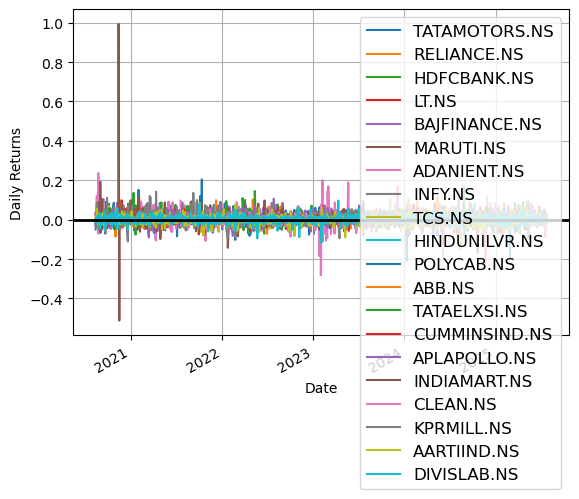

In [4]:
# Plotting the daily returns of each stock
returns.plot(grid=True).axhline(y=0, color="black", lw=2)
plt.legend(loc="upper right", fontsize=12)
plt.ylabel("Daily Returns")

In [5]:
# Defining a function to generate random portfolios
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3, num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(n)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_performance(
            weights, mean_returns, cov_matrix
        )
        results[0, i] = portfolio_std_dev
        results[1, i] = portfolio_return
        results[2, i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [6]:
# Calculating mean returns and covariance matrix of returns
mean_returns = returns.mean()
cov_matrix = returns.cov()

In [7]:
# Setting the number of random portfolios to generate and the risk-free rate
num_portfolios = 50000
risk_free_rate = 0.06

In [8]:
# Defining a function to calculate the negative Sharpe ratio
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

In [9]:
# Defining a function to find the portfolio with maximum Sharpe ratio
def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = {"type": "eq", "fun": lambda x: np.sum(x) - 1}
    bound = (0.0, 1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(
        neg_sharpe_ratio,
        num_assets
        * [
            1.0 / num_assets,
        ],
        args=args,
        method="SLSQP",
        bounds=bounds,
        constraints=constraints,
    )
    return result

In [10]:
# Helper function to calculate portfolio performance
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights) * 252
    std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std_dev, returns

In [11]:
# Calculate portfolio volatility
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix)[0]

In [12]:
# Function to find portfolio with minimum variance
def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    bounds = tuple((0.0, 1.0) for asset in range(num_assets))
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

    result = sco.minimize(portfolio_volatility, [1./num_assets]*num_assets,
                          args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [13]:
# Function to calculate efficient return
def efficient_return(mean_returns, cov_matrix, target_return):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    bounds = tuple((0.0, 1.0) for asset in range(num_assets))
    constraints = [{'type': 'eq', 'fun': lambda x: portfolio_performance(x, mean_returns, cov_matrix)[1] - target_return},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]

    result = sco.minimize(portfolio_volatility, [1./num_assets]*num_assets,
                          args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [14]:
# Function to construct efficient frontier
def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficient_portfolios = []
    for ret in returns_range:
        efficient_portfolios.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficient_portfolios

In [15]:
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    import numpy as np

    n = len(mean_returns)  # 🔧 Fix: number of assets
    results = np.zeros((3, num_portfolios))
    weights_record = []

    for i in range(num_portfolios):
        weights = np.random.random(n)
        weights /= np.sum(weights)
        weights_record.append(weights)

        # Portfolio return and volatility
        portfolio_return = np.dot(weights, mean_returns)
        portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

        # Sharpe Ratio
        sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std_dev

        results[0, i] = portfolio_std_dev
        results[1, i] = portfolio_return
        results[2, i] = sharpe_ratio

    return results, weights_record


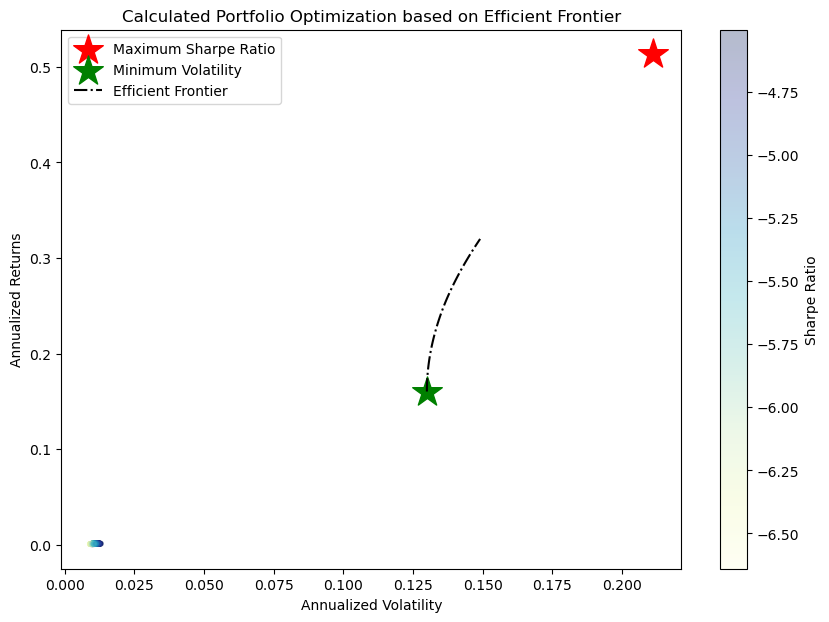

In [16]:
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    # Generating random portfolios for visualization
    results, _ = random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate)

    # Maximum Sharpe Ratio Portfolio
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_performance(max_sharpe["x"], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x, index=mean_returns.index, columns=["Allocation (%)"])
    max_sharpe_allocation *= 100
    max_sharpe_allocation = max_sharpe_allocation.T.round(2)

    # Minimum Volatility Portfolio
    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_performance(min_vol["x"], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x, index=mean_returns.index, columns=["Allocation (%)"])
    min_vol_allocation *= 100
    min_vol_allocation = min_vol_allocation.T.round(2)

    # Efficient Frontier Visualization
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0, :], results[1, :], c=results[2, :], cmap="YlGnBu", marker="o", s=10, alpha=0.3)
    plt.colorbar(label='Sharpe Ratio')
    plt.scatter(sdp, rp, marker="*", color="r", s=500, label="Maximum Sharpe Ratio")
    plt.scatter(sdp_min, rp_min, marker="*", color="g", s=500, label="Minimum Volatility")
    
    target_returns = np.linspace(rp_min, 0.32, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target_returns)
    plt.plot([p["fun"] for p in efficient_portfolios], target_returns, linestyle="-.", color="black", label="Efficient Frontier")
    plt.title("Calculated Portfolio Optimization based on Efficient Frontier")
    plt.xlabel("Annualized Volatility")
    plt.ylabel("Annualized Returns")
    plt.legend()
    plt.show()

display_calculated_ef_with_random(
    mean_returns, cov_matrix, num_portfolios, risk_free_rate
)

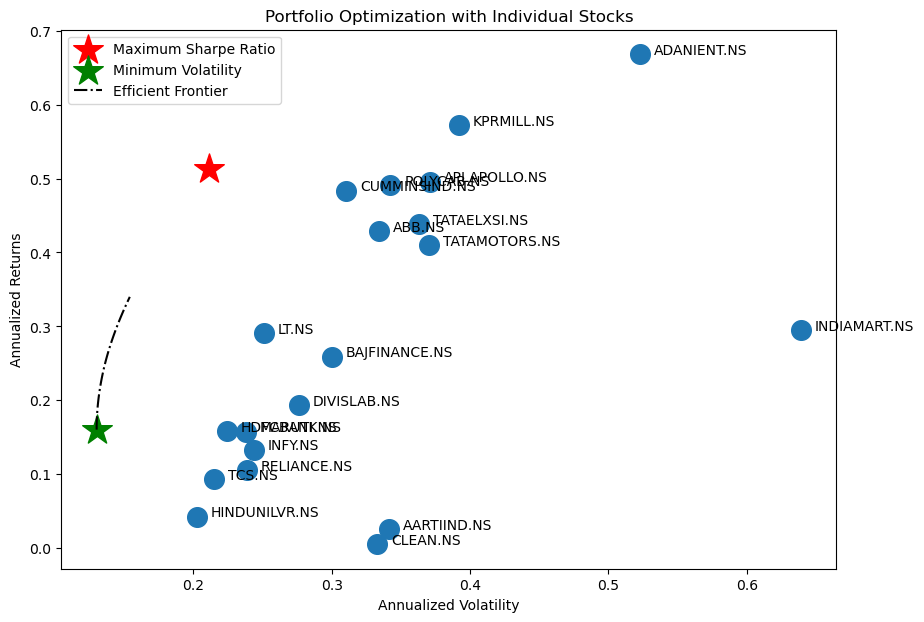

In [17]:
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate):
    # Maximum Sharpe Ratio Portfolio
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_performance(max_sharpe["x"], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x, index=mean_returns.index, columns=["Allocation (%)"])
    max_sharpe_allocation *= 100
    max_sharpe_allocation = max_sharpe_allocation.T.round(2)

    # Minimum Volatility Portfolio
    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_performance(min_vol["x"], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x, index=mean_returns.index, columns=["Allocation (%)"])

    min_vol_allocation *= 100
    min_vol_allocation = min_vol_allocation.T.round(2)

    # Visualization of Individual Stock Returns and Volatility
    an_vol = returns.std(axis=0) * np.sqrt(252)  # <-- Fixed line
    an_rt = mean_returns * 252
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(an_vol, an_rt, marker="o", s=200)
    
    for i, txt in enumerate(mean_returns.index):
        ax.annotate(txt, (an_vol.iloc[i], an_rt.iloc[i]), xytext=(10, 0), textcoords="offset points")
    ax.scatter(sdp, rp, marker="*", color="r", s=500, label="Maximum Sharpe Ratio")
    ax.scatter(sdp_min, rp_min, marker="*", color="g", s=500, label="Minimum Volatility")

    target_returns = np.linspace(rp_min, 0.34, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target_returns)
    ax.plot([p["fun"] for p in efficient_portfolios], target_returns, linestyle="-.", color="black", label="Efficient Frontier")
    ax.set_title("Portfolio Optimization with Individual Stocks")
    ax.set_xlabel("Annualized Volatility")
    ax.set_ylabel("Annualized Returns")
    ax.legend()
    plt.show()

display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)

In [18]:
stocks = close_df
n = 1000  # total port. value

In [19]:
# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(close_df)
S = risk_models.sample_cov(close_df)

In [22]:
# Optimise for maximal Sharpe ratio
ef = EfficientFrontier(mu, S)
raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
ef.portfolio_performance(verbose=True)

# ✅ FIX: Filter close_df before passing to get_latest_prices
selected_stocks = list(cleaned_weights.keys())
filtered_prices_df = close_df[selected_stocks]
latest_prices = get_latest_prices(filtered_prices_df)

# Allocate capital
da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=n)
allocation, leftover = da.lp_portfolio(solver="ECOS_BB")

print("Discrete allocation:", allocation)
print("Funds remaining: ${:.2f}".format(leftover))


Expected annual return: 55.8%
Annual volatility: 21.0%
Sharpe Ratio: 2.65
Discrete allocation: {'AARTIIND.NS': 2}
Funds remaining: $146.00
